# Tutorial 05
## Dimensionality reduction - PCA and LDA

The theoretical background is explained in Lecture 8. Also some useful knowledge can be found in BI-VZD, Lecture 10. Also, you can refresh your knowledge of linear algebra (BI-LIN), especially eigenvalues and eigenvectors.

In [1]:
%%javascript

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import math
from scipy import stats
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, recall_score, accuracy_score
%matplotlib inline
matplotlib.style.use('ggplot')

# Principal Component Analysis (PCA)

PCA is a linear dimensionality reduction technique, exploiting linear relationships between variables to express the information they hold in fewer dimensions.

  * PCA is an example of unsupervised method: we do not use any knowledge of any target variable.
  * Generally speaking it is just an orthogonal projection of $n$-dimensional space to $q$-dimensional space with $q < n$ (usually, but it can be even equal).
  * If $q = 1$, PCA is an ortogonal projection to a line (= $1$-dimensional space).
  * Typically, PCA is applied to centered data, i.e. each feature is centered so that the mean is zero.

### Getting the idea

  * We first generate two dimensional data $X \in \mathbb{R}^{n,2}$.
  * We center them.
  * We depict the projection for a selected line and compute the resulting (sample) variance.

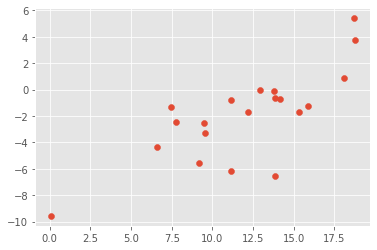

In [3]:
# generating random data via 2-dimensional normal distribution
mean = [12,-2]
cov = np.matrix([[15,8],[8,8]])
n = 20
data = pd.DataFrame(np.random.multivariate_normal(mean, cov, n))
data.columns = ['x', 'y']

plt.scatter(data.x, data.y)

In [4]:
def plot_data_projections(data, projection):
    # number of data
    n = data.shape[0]
    
    # plot the original data
    ig, axs = plt.subplots(1,2, figsize=(14,7))
    actual_mean = data.mean() # mean of original data
    print('Original data mean: ({0:.2f},{1:.2f})'.format(actual_mean[0],actual_mean[1]))
    axs[0].plot(actual_mean[0], actual_mean[1],'ro')
    axs[0].set_title('Original data')
    data.plot.scatter('x', 'y', ax=axs[0])
  
    # center the data 
    data = data - data.mean()
    actual_mean = data.mean() # mean of centered data
    print('Data mean after centering: ({0:.2f},{1:.2f})'.format(actual_mean[0],actual_mean[1]))
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    
    # plot the centered data
    data.plot.scatter('x', 'y', ax=axs[1])
    axs[1].set_title('Centered data')
    
    # define projection vector and normalize it (so its size/lenght is equal to 1)
    projection = [coord/math.sqrt((projection[0]**2 + projection[1]**2)) for coord in projection]
    
    # plot the line given by the projection vector 
    axs[1].plot([-100*projection[0],100*projection[0]],[-100*projection[1], 100*projection[1]],'g-')
    
    # get the orthogonal projections of the data points to the line 
    coordinates = [np.dot(data.iloc[i,:], projection) for i in range(n)] 
    dots = np.matrix([[coordinates[i]*projection[0], coordinates[i]*projection[1]] for i in range(n)]).T
    
    # plot the projections
    axs[1].plot(dots[0], dots[1],'ro')
    
    # variance of projected data points 
    print("Sample variance of projected data: {0:.2f}".format(pd.DataFrame(coordinates).var()[0]))

Original data mean: (11.99,-1.93)
Data mean after centering: (0.00,0.00)
Sample variance of projected data: 11.86


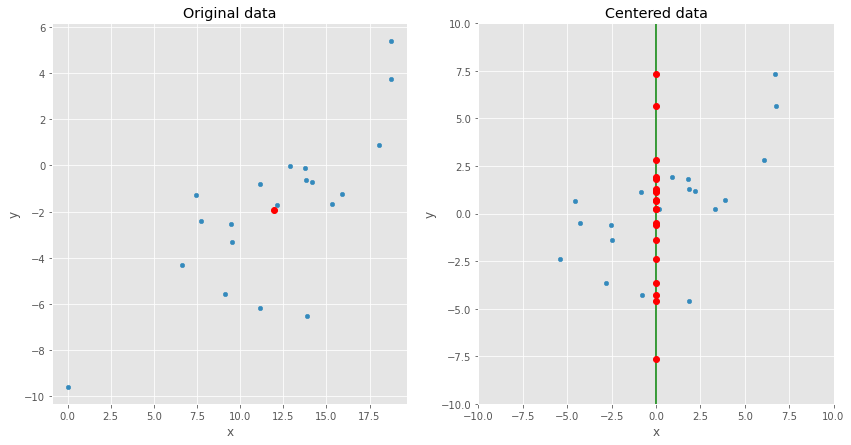

In [5]:
projection = [0,1]
plot_data_projections(data, projection)

### Projection of line given by the first principal component returned by PCA
  * We use sklearn implementation https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html.
  * Compare the resulting variance of projected data points.

Weights of components (eigenvalues):
[29.52533547  3.49422482]
Components (eigenvectors):
[[-0.82387568 -0.56677055]
 [ 0.56677055 -0.82387568]]
Original data mean: (11.99,-1.93)
Data mean after centering: (0.00,0.00)
Sample variance of projected data: 29.53


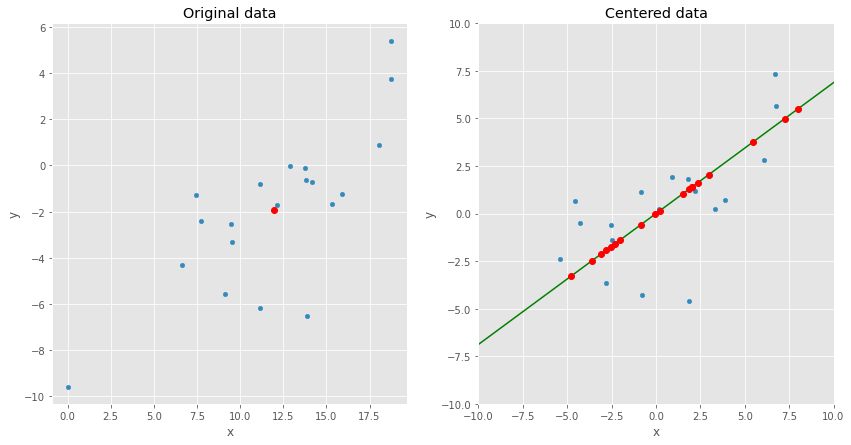

In [10]:
pca = PCA()
pca.fit_transform(data)
print("Weights of components (eigenvalues):")
print(pca.explained_variance_)
print("Components (eigenvectors):")
print(pca.components_)

plot_data_projections(data, pca.components_[0]) # nebo pca.components_[1]

### Mathematics of PCA (just a hint)

Assume the data are stored in the matrix $X \in \mathbb{R}^{n,p}$ and that they are centered, meaning that
$$
    \frac{1}{n}\sum^n_i X_{ik} = 0 \quad \text{for all } k = 0,1,2, \ldots, p-1.
$$
Let $w \in \mathbb{R}^p$ be a unit vector defining the line on which we want to project the data points. Using some linear algebra knowledge we can prove that the coordinates of the projection of $i$th data point $x_i = (X_{i0}, \ldots, X_{i(p-1)})$ is the dot product (in Czech "skalární součin") of $x_i$ and $w$ multiplied by the vector $w$, namely $y_i = (x_i, w)w$.
Since the mean of these points is zero
$$
    \frac{1}{n}\sum^n_i y_i = \frac{1}{n}\sum^n_i (x_i, w) w = \left( \frac{1}{n}\sum^n_i x_i, w \right) w = 0
$$
the variance of these points projections is
$$
    \frac{1}{n}\sum^n_i ||y_i||^2 = \frac{1}{n}\sum^n_i (x_i, w)^2 w^Tw = \{ w \text{ is a unit vector} \} = \frac{1}{n}\sum^n_i (x_i, w)^2 = \frac{1}{n}(Xw)^T(Xw) = w^T\frac{X^TX}{n}w.
$$
So, denoting $V = \frac{X^TX}{n}$ (note that it is the covariance matrix of the centered data), we are looking for $w \in \mathbb{R}^p$ such that
$$
    w^TVw \text{ is maximum possible} \quad \text{and} \quad w^Tw = ||w||^2 = 1.
$$

In words, **we are looking for the projection line so that the variance of orthogonally projected points on this line is maximum possible**.

Using the method of Lagrange multipliers for optimisation with constraints (see the NI-MPI course) we get that the maximum value is attained if $w$ is a unit eigenvector of $V$ corresponding to the greatest eigenvalue $\lambda_0$ (all eigenvalues of a positive definite matrix are positive real numbers). Note that then $w^TVw = \lambda$. 

This idea can be applied repetitively (with some details we omit here). All in all, the eigenvectors are called **principal components**, they are known to be mutually orthogonal. The first principal component is the one with the greatest eigenvector, the second principal component is the one with the second greatest eigenvector and so on.

### Using PCA to visualize multidimensional data
  * Data with $p$ features can be understood as a set of vectors in $p$-dimensional vector space $\mathbb{R}^p$.
  * First two principal components given by PCA define a 2-dimensional space a.k.a. a plane.
  * If we project all data points on this plane, we get a 2D chart where the points are "parted" as much as possible.


In [11]:
# generating random data using p-dimensional normal distribution
p = 10
n = 100
mean = np.random.rand(p)*10
A = np.random.rand(p,p) # Random values in a given shape from a uniform distribution.
offset = np.diag(np.full(p, 20))
cov = A.T*A + offset
data = pd.DataFrame(np.random.multivariate_normal(mean, cov, n))
data = data - data.mean() # not necessary

In [12]:
pca = PCA(n_components=2)
pca.fit_transform(data)
print("Weights of components (eigenvalues):")
print(pca.explained_variance_)
print("Components (eigenvectors):")
print(pca.components_)

Weights of components (eigenvalues):
[31.20781731 27.09830164]
Components (eigenvectors):
[[ 0.09033784  0.20752271 -0.12401493 -0.35091288 -0.4103476   0.38421459
  -0.55525843 -0.20760186 -0.28184534 -0.25179475]
 [-0.36164192  0.40262994  0.54947909 -0.16092231  0.4313965   0.13871882
  -0.25733147 -0.17979214  0.11808121  0.24788559]]


,PCA1,PCA2
0,-14.005789,5.870635
1,-5.103004,-1.048612
2,2.539078,1.576287
3,4.656272,0.557052
4,3.412421,-6.424710


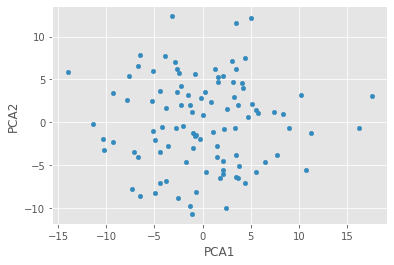

In [13]:
projected_data = pd.DataFrame(pca.transform(data))
projected_data.columns = ['PCA1', 'PCA2']
projected_data.plot.scatter('PCA1', 'PCA2')
projected_data.head()

In [14]:
# just to check that what we have said above
# the projection coordinate of the first data point should equal the dot product (w,x_0)
# where w is the corresponding principal component
PCA1 = (np.matrix(pca.components_[0])*np.matrix(data.loc[0,:]).T)[0,0]
PCA2 = (np.matrix(pca.components_[1])*np.matrix(data.loc[0,:]).T)[0,0]
PCA1sklearn = projected_data.iloc[0,0]
PCA2sklearn = projected_data.iloc[0,1]
print("Coordinate of the first data point projection using sklearn: {0:.5f}, {1:.5f}".format(PCA1sklearn, PCA2sklearn))
print("Coordinate of the first data point projection using direct computation: {0:.5f}, {1:.5f}".format(PCA1, PCA2))

Coordinate of the first data point projection using sklearn: -14.00579, 5.87063
Coordinate of the first data point projection using direct computation: -14.00579, 5.87063


### Using PCA as a dimensionality reduction tool
  * For high dimension data with a lot of features we can use the PCA to lower the number of features.
  * More precisely: instead of $n$ features we use their projections to $q < n$ principal component.

In [15]:
# loading and centering
# these are the cleaned data from tutorial 3 with indicator features dropped
data = pd.read_csv('dataForPCA.csv')
data = data.drop([data.columns[0],data.columns[1]], axis=1) # drop the Id columns
data = data - data.mean()
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SqrtGrLivArea,LogGrLivArea,SqrtGarageArea,LogGarageArea,SqrtWoodDeckSF,LogWoodDeckSF,SqrtOpenPorchSF,LogOpenPorchSF,SqrtPoolArea,LogPoolArea
0,3.383562,26.420091,473.027397,0.902283,-0.585388,35.144292,21.346119,-103.50137,-442.947945,-47.037443,...,-0.187151,0.018123,0.046174,0.238169,-6.507256,-2.472772,-4.660480,-2.269256,-0.152967,-0.040575
1,-36.616438,19.420091,1460.027397,-0.097717,0.414612,10.144292,-3.653881,106.49863,145.052055,180.962557,...,-0.635303,-0.005489,3.069997,0.506967,10.105992,3.151245,-4.660480,-2.269256,-0.152967,-0.040575
2,-36.616438,-58.579909,1087.027397,-0.097717,0.414612,-0.855708,-14.653881,467.49863,-442.947945,-47.037443,...,-0.371044,0.008467,3.869190,0.572371,12.754104,3.446121,-4.660480,-2.269256,-0.152967,-0.040575
3,-36.616438,22.420091,586.027397,1.902283,-0.585388,35.144292,21.346119,-103.50137,-442.947945,-47.037443,...,0.242844,0.040519,6.926773,0.804565,-6.507256,-2.472772,7.171679,2.679504,-0.152967,-0.040575
4,133.383562,9.420091,250.027397,-1.097717,-0.585388,-20.855708,-34.653881,-103.50137,597.052055,-47.037443,...,-4.227274,-0.205536,-5.438070,-0.366079,-6.507256,-2.472772,2.267723,1.622564,-0.152967,-0.040575


### Linear regression without PCA

In [16]:
dtrain, dtest = train_test_split(data, test_size=0.25, random_state=17)
X = dtrain.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dtrain.SalePrice
Xtest = dtest.drop(['SalePrice'], axis = 1, errors = 'ignore')
ytest = dtest.SalePrice

# Linear Regression
clf1 = LinearRegression()
clf1.fit(X, y) 

# RMSE
RMSE = np.sqrt(mean_squared_error(clf1.predict(Xtest), ytest))
print('Root mean squared error:', RMSE)

Root mean squared error: 0.1275452114396475


### Linear regression with PCA

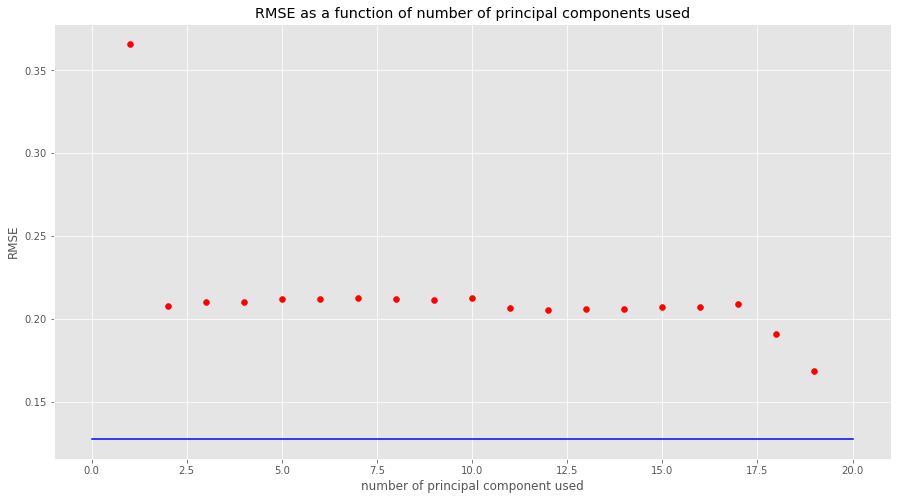

In [17]:
q = 20 # max. number of components

pca = PCA()
pca.fit(X)
X1 = pca.transform(X)
Xtest1 = pca.transform(Xtest)

RMSE_PCA = []

for n in range(1,q):
    Xsub1 = X1[:,0:n]
    Xsubtest1 = Xtest1[:,0:n]
    clf1 = LinearRegression()
    clf1.fit(Xsub1, y) 
    # save RMSE
    RMSE_PCA.append(np.sqrt(mean_squared_error(clf1.predict(Xsubtest1), ytest)))
    
plt.subplots(1,1, figsize=(15, 8))
ns = plt.scatter(range(1,q), RMSE_PCA, c='red')
plt.title(u"RMSE as a function of number of principal components used")
plt.xlabel(u'number of principal component used')
plt.ylabel('RMSE')
plt.plot([0, q], [RMSE, RMSE],'b-') # linreg without PCA

# Linear Discriminant Analysis (LDA)

  * It is another projection to a lower-dimensional subspace.
  * It is applicable on **classification data**, i.e. the target variable is known and categorical.
  * To get the idea let us assume the projection of data to a line and two categories:
    * Let $\mu_1$ and $\mu_2$ are means of the projected data points of the two catoegories, respectively.
    * Similarly, assume $\sigma^2_1$ and $\sigma^2_2$ are the sample variances of the projected data points.
    * The goal of the LDA is to find the line so that the means $\mu_1$ and $\mu_2$ are far away from each other but at the same time the sum of variances $\sigma^2_1 + \sigma^2_2$ is low.
    * Details can be found below, in words we can say that LDA is looking for the projection maximizing **separability** of the data points from distinct categories.

### Projection of 2D data to a line

,x,y,c
0,2.553146,1.563232,0
1,7.376551,4.304333,0
2,-0.288255,-2.771621,0
3,1.879638,3.513383,0
4,2.677970,0.637416,0


(-15.0, 15.0)

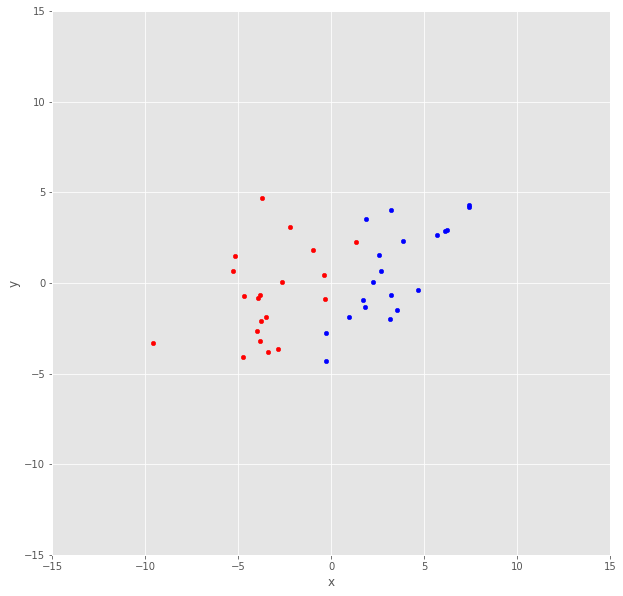

In [18]:
# generate random data using 2 data sets both generated via 2-dimensional normal distribution
mean1 = [12,-2]
cov1 = np.matrix([[5,4],[4,8]])
n1 = 20
mean2 = [4,-4]
cov2 = np.matrix([[10,4],[4,8]])
n2 = 20 

data1 = pd.DataFrame(np.random.multivariate_normal(mean1, cov1, n1))
data1['class'] = np.full(n1,0).T
data2 = pd.DataFrame(np.random.multivariate_normal(mean2, cov2, n2))
data2['class'] = np.full(n2,1).T

data = pd.concat([data1, data2])
data.columns = ['x','y','c']

# centering the data
data[['x','y']] = data[['x','y']] - data[['x','y']].mean()
display(data.head())

# plot the original data
lim = 15
mean_all = data[['x', 'y']].mean()
ig, ax = plt.subplots(1,1,figsize=(10, 10))
data[data['c'] == 1].plot.scatter('x', 'y', c = 'red', ax=ax)
data[data['c'] == 0].plot.scatter('x', 'y', c = 'blue', ax=ax)
plt.xlim(mean_all[0]-lim,mean_all[0] + lim)
plt.ylim(mean_all[1]-lim,mean_all[1] + lim)

In [19]:
def plot_data_projections(data, projection):
    mean = []
    var = []
    lim = 15
    
    #number of data
    n = data.shape[0]
    
    # plot the original data
    mean_all = data[['x', 'y']].mean()
    ig, ax = plt.subplots(1,1,figsize=(10, 10))
    data[data['c'] == 1].plot.scatter('x', 'y', c = 'red', ax=ax)
    data[data['c'] == 0].plot.scatter('x', 'y', c = 'blue', ax=ax)
    plt.xlim(mean_all[0]-lim,mean_all[0] + lim)
    plt.ylim(mean_all[1]-lim,mean_all[1] + lim)
    
    # define and normalize the projection vector
    projection = [coord/math.sqrt((projection[0]**2 + projection[1]**2)) for coord in projection]
    
    # plot the line given by the projection vector 
    ax.plot([-10*lim*projection[0],10*lim*projection[0]],[-10*lim*projection[1], 10*lim*projection[1]],'g-')
    
    # get the orthogonal projections of the data points to the line
    colors = ['b','r']
    for k in [0,1]:
        color = colors[k]
        cat = data[data['c'] == k]
        coordinates = [np.dot(cat.iloc[i,0:2], projection) for i in range(cat.shape[0])]
        dots = np.matrix([[coordinates[i]*projection[0], coordinates[i]*projection[1]] for i in range(cat.shape[0])]).T
        # plotting the projections
        ax.plot(dots[0], dots[1], color + 'x')
        # variance of projected data points
        distances = pd.DataFrame(coordinates)
        var.append(distances.var()[0])
        mean.append(distances.mean()[0])
    return mean, var

Categories means: 2.86, -2.86
Categories sample variances: 10.31, 7.90
Objective function: 1.79


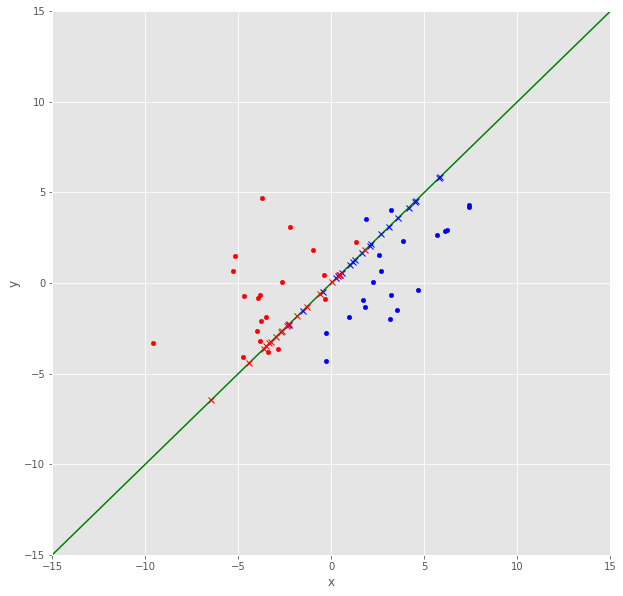

In [20]:
mean, var = plot_data_projections(data,[1,1])
print("Categories means: {0:.2f}, {1:.2f}".format(mean[0], mean[1]))
print("Categories sample variances: {0:.2f}, {1:.2f}".format(var[0], var[1]))
objective = (mean[0] - mean[1])**2/(var[0] + var[1])
print("Objective function: {0:.2f}".format(objective))

### Projection line given by LDA
  * We use sklearn implementation https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html.
  * Compare the resulting objective function value of projected data points.
  
Quite good explanation of LDA: http://www.sci.utah.edu/~shireen/pdfs/tutorials/Elhabian_LDA09.pdf.

Categories means: -2.90, 2.90
Categories sample variances: 2.34, 3.84
Objective function: 5.43


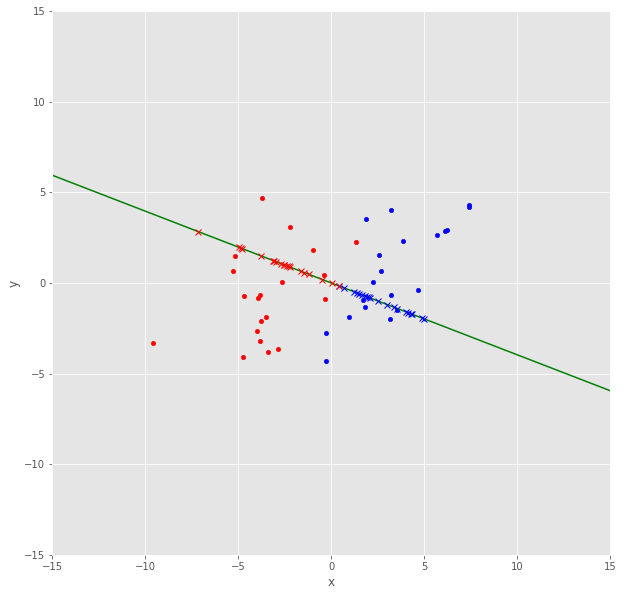

In [21]:
clf = LinearDiscriminantAnalysis(n_components=1, solver='svd', shrinkage=None).fit(data[['x','y']], data['c'])
mean, var = plot_data_projections(data, clf.coef_[0])
print("Categories means: {0:.2f}, {1:.2f}".format(mean[0], mean[1]))
print("Categories sample variances: {0:.2f}, {1:.2f}".format(var[0], var[1]))
objective = (mean[0] - mean[1])**2/(var[0] + var[1])
print("Objective function: {0:.2f}".format(objective))

### Mathematics of LDA (just a hint)

Assume the data are stored in the matrix $X \in \mathbb{R}^{n,p}$ and that there are $K$ classes (categories) of data points. Let us denote $N_c$ the number of points on class $c$. The class is indicated in target variable $Y \in \mathbb{R}^{n,1}$. Let $\mu \in \mathbb{R}^p$ be the mean vector of all data and $\mu_c$ the mean vectors for class $c \in \{1,2, \ldots, K\}$.

We define **scatter matrices** from $\mathbb{R}^{p,p}$
$$
    S_B = \sum_{c = 1}^K N_c (\mu_c - \mu)(\mu_c - \mu)^T
$$
and
$$
    S_W = \sum_{c = 1}^K \sum_{i \in \text{class}_c} (x_i - \mu_c)(x_i - \mu_c)^T
$$
where by $i \in \text{class}_c$ we mean that $i$ is an index of a data point in class $c$.

Let $w \in \mathbb{R}^{p}$ be a vector that define a projection line. Then LDA looks for $w$ that maximizes the objective function
$$
    J(w) = \frac{w^T S_B w}{w^T S_W w}.
$$
Again using the method of Lagrange multipliers for optimisation with constraints we get that the (mutually orthogonal) local extremal values are attained if $w$ is an eigenvector of the matrix $S_W^{-1}S_B$. The corresponding eigenvalue $\lambda$ is again the value of the objective function, i.e., $J(w) = \lambda$. Note that the rank of $S_B$ is at most $K - 1$ and hence the maximum number of nonzero eigenvalues is also at most $K - 1$.

### Using LDA to visualize multidimensional data
  * We will use the famous iris data.

Shape of X with PCA:  (150, 4)
Shape of X with LDA:  (150, 2)


Text(0, 0.5, 'LDA2')

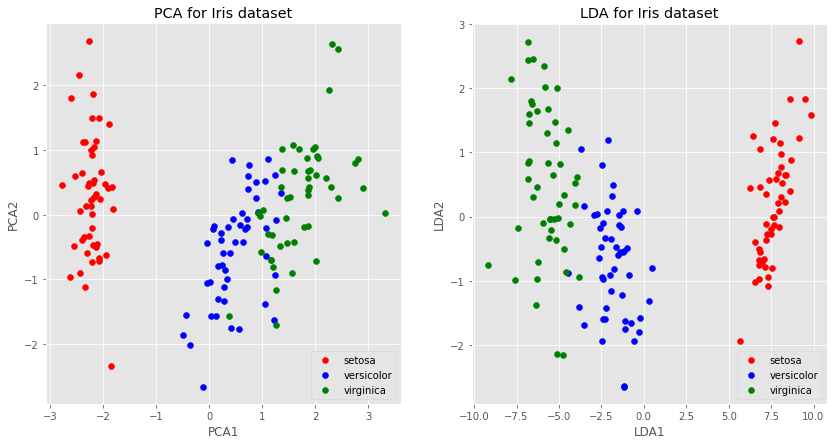

In [22]:
# source: https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = iris.data
y = iris.target
y_names = iris.target_names

#print('Shape of X: ', X.shape, ' and y: ', y.shape)

X = StandardScaler().fit_transform(X)

# PCA
pca = PCA()
pca.fit(X)
Xpca = pca.transform(X)
print('Shape of X with PCA: ', Xpca.shape)

# LDA
lda = LinearDiscriminantAnalysis() # n_components <= min(n_classes-1, n_features)
lda.fit(X, y)
Xlda = lda.transform(X)
print('Shape of X with LDA: ', Xlda.shape)

ig, ax = plt.subplots(1,2,figsize=(14, 7))
colors = ['red', 'blue', 'green']

for i in [0, 1, 2]:
    ax[0].scatter(Xpca[y == i, 0], Xpca[y == i, 1], color=colors[i], label=y_names[i])
ax[0].legend()
ax[0].set_title('PCA for Iris dataset')
ax[0].set_xlabel('PCA1')
ax[0].set_ylabel('PCA2')

for i in [0, 1, 2]:
    ax[1].scatter(Xlda[y == i, 0], Xlda[y == i, 1], color=colors[i], label=y_names[i])
ax[1].legend()
ax[1].set_title('LDA for Iris dataset')
ax[1].set_xlabel('LDA1')
ax[1].set_ylabel('LDA2')

### Classification using LDA and comparison with other methods

In [23]:
# load digits data - MNIST 8x8
digits = datasets.load_digits()
pd.DataFrame(digits.data).head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


(1347, 64) (450, 64) (1347,) (450,)

Accuracy of classifier: 0.8867

Accuracy of LDA as classifier: 0.9711

Accuracy of classifier with LDA: 0.5489


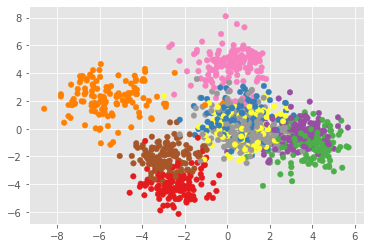

Accuracy of classifier with PCA: 0.8244


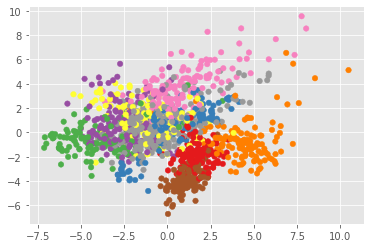

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

X = digits.data
y = digits.target

X, Xtest, y, ytest = train_test_split(X, y, test_size=0.25)
print(X.shape, Xtest.shape, y.shape, ytest.shape)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
Xtest = scaler.transform(Xtest)

# Some classifier
clf = DecisionTreeClassifier()
#clf = LogisticRegression() 
clf.fit(X, y) 
y_pred = clf.predict(Xtest)
acc_logreg = accuracy_score(ytest, y_pred)
print('\nAccuracy of classifier: {0:.4f}'.format(acc_logreg))

# LDA as classifier
lda = LinearDiscriminantAnalysis(n_components=2)
Xlda = lda.fit(X, y).transform(X)
y_lda = lda.predict(Xtest)
acc_lda = accuracy_score(ytest, y_lda)
print('\nAccuracy of LDA as classifier: {0:.4f}'.format(acc_lda))

# LDA as dimensionality reduction, classifier
clf.fit(Xlda, y)
y_combined = clf.predict(lda.transform(Xtest)) # same LDA model as above
acc_combined = accuracy_score(ytest, y_combined)
print('\nAccuracy of classifier with LDA: {0:.4f}'.format(acc_combined))

# plot first 2 components
plt.figure()
plt.scatter(Xlda[:, 0], Xlda[:, 1], c=y, s=30, cmap='Set1')
plt.show()

# PCA as dimensionality reduction, classifier
pca = PCA(n_components=10) # try various num. of PC
pca.fit(X)
Xpca = pca.transform(X)
Xpca_test = pca.transform(Xtest)

clf.fit(Xpca, y)
y_pca = clf.predict(Xpca_test)
acc_pca = accuracy_score(ytest, y_pca)
print('Accuracy of classifier with PCA: {0:.4f}'.format(acc_pca))

# plot first 2 components
plt.figure()
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=y, s=30, cmap='Set1')
plt.show()

### Manifold learning - LLE example

Accuracy of classifier with LLE: 0.3956


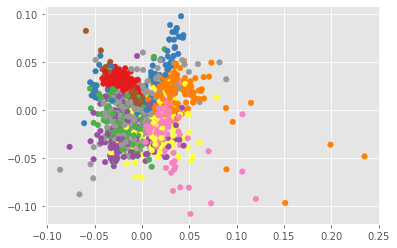

In [25]:
# locally linear embedding (LLE)
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, method='standard', n_neighbors=30)
lle.fit(X)
Xlle = lle.transform(X)
Xlle_test = lle.transform(Xtest)

clf.fit(Xlle, y)
y_lle = clf.predict(Xlle_test)
acc_lle = accuracy_score(ytest, y_lle)
print('Accuracy of classifier with LLE: {0:.4f}'.format(acc_lle))

# plot first 2 components
plt.figure()
plt.scatter(Xlle[:, 0], Xlle[:, 1], c=y, s=30, cmap='Set1')
plt.show()

Last point: nowadays popular visualization and dimensionality reduction method is [t-SNE](https://lvdmaaten.github.io/tsne/).
